In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import time
from scipy.optimize import minimize
from climin.util import optimizer
import theano
import theano.tensor as T
from itertools import izip

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from schlichtanders.myoptimizers import batch
from schlichtanders.myfunctools import compose

In [4]:
from theano_models import (Merge, as_tensor_variable,
                           reparameterize_map, softplus, softplus_inv, squareplus, squareplus_inv)
                           
from theano_models.postmaps import (scipy_postmap, climin_postmap, flat_numericalize_postmap, flatten_parameters,
                                    deterministic_optimizer_postmap, probabilistic_optimizer_postmap)

import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm

# Deterministic Model - one dimensional

## model

In [ ]:
model = dm.RadialTransform()
model

TODO softplus gives immediate precision loss, while e.g. squarepos works like a charm

    # model.map('parameters_positive', reparameterize_map(softplus, softplus_inv), 'parameters')

In [ ]:
model.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
model

## target

In [ ]:
target = dm.RadialTransform(init_alpha=1, init_beta=20, init_z0=[3])

In [ ]:
f_target = target.function()
example_target = [7]
f_target(example_target)  # caution, needs vector not scalar input

In [ ]:
N = 40
xs = np.linspace(-10, 10, N)[:, np.newaxis]
xs[:7]

In [ ]:
ys = np.array([f_target(x) for x in xs])
ys[:7]

## visualization

In [ ]:
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    ax.clear() # interactive
    # target data:
    ax.plot(xs, ys, 'k:')
    
    # model:
    f_model = model.function(givens=givens)
    model_ys = np.array([f_model(x) for x in xs])
    ax.plot(xs, model_ys, 'r')
    
    fig.canvas.draw()
    time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
postmap = compose(scipy_postmap, flat_numericalize_postmap, flatten_parameters, deterministic_optimizer_postmap)
scipy_kwargs = postmap(model, wrapper=batch, initial_inputs=[example_target])
scipy_kwargs

In [ ]:
fit = minimize(
    args=(ys,xs),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit(fig, ax, {model['parameters_flat'][0]:xs}),
    **scipy_kwargs
); fit

Fix fitted parameters into model.

We need to further build a givens dictionary supply the input-info which usually is given when used as theano.function(model['inputs'], model['outputs']).

In [ ]:
model['parameters_flat'] = [fit.x]
givens = dict(izip(model['inputs'], [example_target]))

In [ ]:
[(p.name, p.eval(givens)) for p in model['parameters_positive']]

In [ ]:
[(p.name, p.eval(givens)) for p in model['parameters']]

# two dimensions

## model

In [ ]:
model2d = dm.RadialTransform()
model2d

In [ ]:
model2d.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
model2d

## target

In [ ]:
target2d = dm.RadialTransform(init_alpha=1, init_beta=5, init_z0=[3, 1])
# target2d = dm.RadialTransform(init_alpha=50, init_beta=-40, init_z0=[3, 1])

In [ ]:
f_target2d = target2d.function()
example_target2d = [7, 4]
f_target2d(example_target2d)  # caution, needs vector not scalar input

In [ ]:
N2d = 10
_xs = np.linspace(-10, 10, N2d)
X1, X2 = np.meshgrid(_xs, _xs)
xs2d = np.c_[X1.flat, X2.flat]
xs2d[:5]

In [ ]:
ys2d = np.array([f_target2d(x) for x in xs2d])
ys2d[:5]

## visualization

In [ ]:
diff2d = ys2d - xs2d
quiver_kwargs = dict(scale=1, angles='xy', scale_units='xy', width=0.003)

def plot_fit2d(fig, ax, givens={}, time_delay=0.1, expand_factor=0.4):
    ax.clear()
    
    # target data:
    ax.quiver(xs2d[:,0], xs2d[:,1], diff2d[:,0], diff2d[:,1], hatch='***', facecolor='none', color="k", **quiver_kwargs)
    
    # model:
    f_model2d = model2d.function(givens=givens)
    m_ys2d = np.array([f_model2d(x) for x in xs2d])
    m_diff2d = m_ys2d - xs2d
    ax.quiver(xs2d[:,0], xs2d[:,1], m_diff2d[:,0], m_diff2d[:,1], color="r", **quiver_kwargs)

    # ax.autoscale()  # does not work with arrows, do it manually:
    l, r, b, t = ax.axis()
    dx, dy = r - l, t - b
    ax.axis([l - expand_factor * dx, r + expand_factor * dx, b - expand_factor * dy, t + expand_factor * dy])
    
    fig.canvas.draw()
    time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit2d(fig, ax)

## fit

In [ ]:
postmap = compose(scipy_postmap, flat_numericalize_postmap, flatten_parameters, deterministic_optimizer_postmap)
scipy_kwargs2d = postmap(model2d, wrapper=batch, initial_inputs=[example_target2d])
scipy_kwargs2d

In [ ]:
fit = minimize(
    args=(ys2d,xs2d),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit2d(fig, ax, {model2d['parameters_flat'][0]:xs}),
    **scipy_kwargs2d
); fit

# Probabilistic Normalizing Flow

Only the combination with gaussian base function is shown. The uniform base function has the disadvantage of not being differentiable (not yet supported).

## model

In [5]:
base_model = pm.DiagGauss(output_size=2)
# CAUTION, this transform cannot be reused elsewhere, as it is merged into normalizing flow
# its references point always to the current substitution
transform_model = dm.RadialTransform()

In [6]:
pm.normalizing_flow(transform_model, base_model)
model = Merge(transform_model, base_model)
model

{ 'inputs': [],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'logP': <FunctionWrapper at 0x7fe315e1cf30 for function at 0x7fe3561e2f50>,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0, mean],
  'parameters_positive': [alpha, beta+alpha, var]}

In [7]:
model.map('parameters_positive',reparameterize_map(squareplus, squareplus_inv), 'parameters')
model

{ 'inputs': [],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'logP': <FunctionWrapper at 0x7fe315e1cf30 for function at 0x7fe3561e2f50>,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [ z0,
                  mean,
                  alpha_copy_squareplus,
                  beta+alpha_copy_squareplus,
                  var_copy_squareplus],
  'parameters_positive': [alpha_reparam, beta+alpha_reparam, var_reparam]}

## target

In [8]:
base_target = pm.DiagGauss(init_mean=[5,5], init_var=(10,5))
transform_target = dm.RadialTransform(init_z0=[5,5], init_beta=30, init_alpha=3)

In [9]:
pm.normalizing_flow(transform_target, base_target)
target = Merge(transform_target, base_target)
t_sampler = target.function()
t_sampler()

array([-13.75825768, -10.02588582])

In [10]:
n_samples = 2000
targets = np.array([t_sampler() for _ in xrange(n_samples)])

## visualization

In [11]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_sampler = model.function(givens=givens)
    m_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

<IPython.core.display.Javascript object>


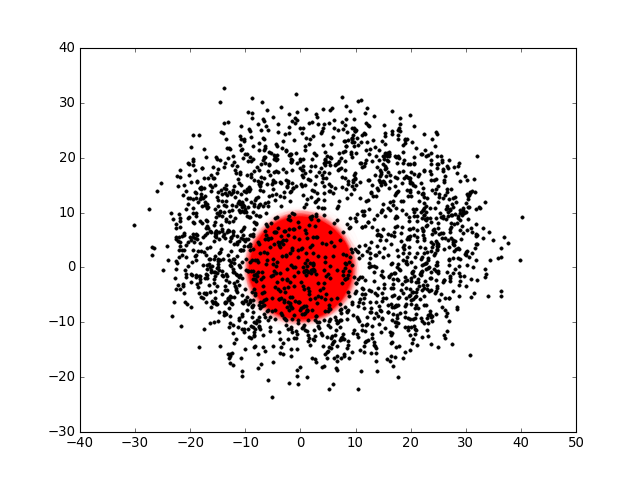

In [12]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
postmap = compose(scipy_postmap, flat_numericalize_postmap, flatten_parameters, probabilistic_optimizer_postmap)
scipy_kwargs = postmap(model, wrapper=batch, initial_inputs=[])

RuntimeError: maximum recursion depth exceeded while calling a Python object

In [ ]:
myoptimizer = opt.ScipyOptimizer(batch)
# CAUTION: scipy args needs to be tuple in order to work as expected!
myoptimizer.optimize(
    model, args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':10000, 'disp':True},
    callback=lambda x: plot_fit(fig, ax, time_delay=0.001)
)

In [ ]:
alpha = transform_model.alpha_from_Alpha(transform_model._Alpha.get_value(), module=np)
beta = transform_model.beta_from_Beta(alpha, transform_model._Beta.get_value(), module=np)
print alpha, beta